# Import

In [1]:
%load_ext autoreload
%autoreload 2

import fastai
from fastai import *
from fastai.vision import *

In [2]:
fastai.__version__

'1.0.57'

# Config

In [3]:
lesson_dir_path = Path('lesson7-resnet-mnist')

In [4]:
path = untar_data(URLs.MNIST)
path

PosixPath('/home/justin/.fastai/data/mnist_png')

# Lesson

In [5]:
il = ImageList.from_folder(path, convert_mode='L')

In [6]:
il.items[0]

PosixPath('/home/justin/.fastai/data/mnist_png/testing/5/1144.png')

In [7]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/justin/.fastai/data/mnist_png

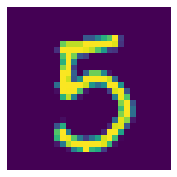

In [8]:
il[0].show()

In [9]:
sd = il.split_by_folder(train='training', valid='testing')

In [10]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/justin/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/justin/.fastai/data/mnist_png;

Test: None

In [11]:
ll = sd.label_from_folder()

In [12]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
5,5,5,5,5
Path: /home/justin/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
5,5,5,5,5
Path: /home/justin/.fastai/data/mnist_png;

Test: None

In [13]:
X, y = ll.train[0]

(None, Category 5)

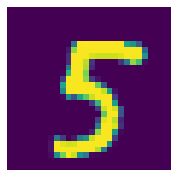

In [14]:
X.show(), y

In [15]:
# No transforms for validation set
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [16]:
ll = ll.transform(tfms)

In [17]:
batch_size = 128

In [18]:
data = ll.databunch(bs=batch_size).normalize()

(None, Category 5)

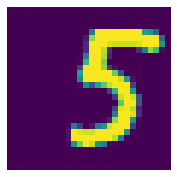

In [19]:
X,y = data.train_ds[0]
X.show(), y

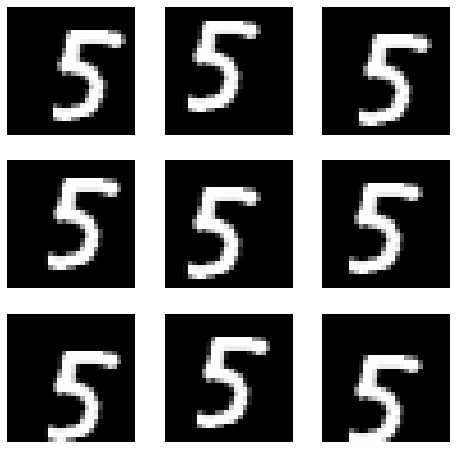

In [20]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

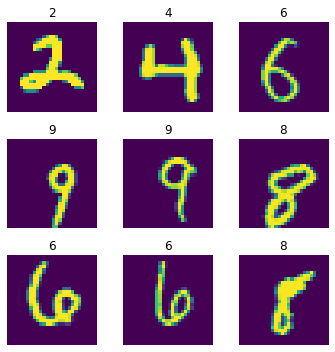

In [21]:
data.show_batch(rows=3, figsize=(5,5))

## Basic CNN with batchnorm

In [22]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [23]:
model = nn.Sequential(
    conv(1, 8),   # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16),  # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)


In [24]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [25]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [26]:
X,y = data.one_batch()

In [27]:
model(X.cuda()).shape

torch.Size([128, 10])

In [28]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


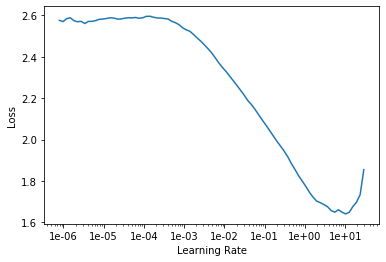

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.226520,0.378818,0.880900,00:04
1,0.141459,0.083233,0.973100,00:04
2,0.081164,0.041420,0.987400,00:05


## Refactor

In [31]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [32]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [33]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [34]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.246003,0.160559,0.952400,00:04
1,0.189711,0.265446,0.911100,00:04
2,0.171913,0.111214,0.964600,00:04
3,0.149582,0.128028,0.958600,00:04
4,0.122836,0.083328,0.973900,00:05
5,0.108703,0.206140,0.932500,00:05
6,0.087479,0.055561,0.982500,00:05
7,0.064786,0.049081,0.983100,00:05
8,0.053171,0.028175,0.990200,00:05
9,0.048078,0.026949,0.991200,00:05


## Resnet-ish

In [35]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [36]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [37]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [38]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [39]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


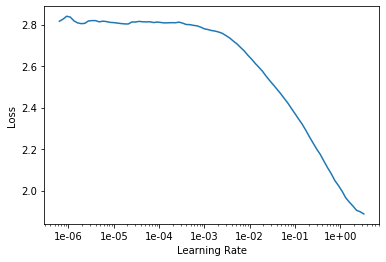

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.196036,0.141368,0.960100,00:06
1,0.124420,0.142854,0.957000,00:07
2,0.109352,0.169411,0.940300,00:07
3,0.089090,0.188017,0.939900,00:07
4,0.066164,0.057741,0.981400,00:07
5,0.063153,0.038205,0.987500,00:07
6,0.058084,0.051741,0.983300,00:07
7,0.038941,0.044741,0.985800,00:07
8,0.035886,0.025849,0.991800,00:07
9,0.027844,0.019039,0.994700,00:07


In [42]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________